In [1]:
import os
from pathlib import Path

from itertools import chain, product

import datetime

import math
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import datetime
import pymmwr

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

# https://github.com/reichlab/timeseriesutils
from timeseriesutils import featurize

In [2]:
def get_season_hol(start_year):
  holiday_cal = USFederalHolidayCalendar()
  hol = holiday_cal.holidays(
    start=datetime.datetime(year=start_year, month=7, day=1),
    end=datetime.datetime(year=start_year+1, month=6, day=1),
    return_name=True)
    
  hol = hol.reset_index()
  hol.columns = ['date', 'holiday']
  hol = hol.loc[hol['holiday'].isin(['Thanksgiving Day', 'Christmas Day'])]
  
  hol['season'] = str(start_year) + '/' + str(start_year + 1)[-2:]
  
  return hol

# convert epi week to season week
def convert_epiweek_to_season_week(epiweek):
  """Convert season and epiweek to season and season week.
  Args:
      epiweek in format 'yyyyww'
  Return:
      season_week: integer between 1 and 52
  """
  epiweek_year = epiweek.str[:4].astype(int)
  epiweek_week = epiweek.str[4:].astype(int)
  
  season_week = epiweek_week - 30

  if season_week <= 0:
        season_week += pymmwr.epiweeks_in_year(epiweek_year - 1)
  

  #update_inds = (season_week <= 0)
  #season_week[update_inds] = season_week[update_inds] + \
  #  [pymmwr.epiweeks_in_year(int(epiweek_year[update_inds].values[i]) - 1) for i in range(np.sum(update_inds))]
  
  return season_week


def epiweek_to_season_week(iso_week):
    """Convert ISO week to season week."""
    return iso_week - 30 if iso_week > 30 else iso_week + 22

def convert_datetime_to_season_week(row, date_col_name):
  ew = pymmwr.date_to_epiweek(row[date_col_name].date())
  #ew_str = pd.Series(str(ew.year) + str(ew.week))
  ew_str = str(ew.year) + str(ew.week)
  return convert_epiweek_to_season_week(ew_str)


def get_holidays():
  hol = pd.concat([get_season_hol(sy) for sy in range(1997, 2024)],
                  ignore_index=True)
  #hol['season_week'] = hol.apply(convert_datetime_to_season_week, axis=1, date_col_name='date')
  hol['epiweek_week'] = hol['date'].dt.isocalendar().week
  hol['season_week'] = hol['epiweek_week'].apply(epiweek_to_season_week)

  return hol[['season', 'holiday', 'date', 'season_week']]


In [3]:
# config settings

# date of forecast generation
forecast_date = datetime.date(2024, 3, 24)

# maximum forecast horizon
max_horizon = 4

# bagging setup
num_bags = 100
bag_frac_samples = 0.7

# quantile levels at which to generate predictions
q_levels = [0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35,
            0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80,
            0.85, 0.90, 0.95, 0.975, 0.99]
q_labels = ['0.01', '0.025', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35',
            '0.4', '0.45', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8',
            '0.85', '0.9', '0.95', '0.975', '0.99']

In [4]:
os.chdir('/Users/dk29776/Dropbox/UTAustin/Forecasting')

In [5]:
data = pd.read_csv('NHSN/data/city_level_data.csv')
data


,Unnamed: 0,collection_week,state,city,inpatient_beds_7_day_avg,total_icu_beds_7_day_avg,influenza_7_day_avg,influenza_7_day_sum,influenza_and_covid_7_day_avg,influenza_and_covid_7_day_sum,state.y,city_estimate_2023,city_2023,state_2023_estimate,state_2023
0,1,2019-12-29,AL,BIRMINGHAM,0.0,0.0,0.0,0,0.0,0,Alabama,"196,644",196644.0,"5,108,468",5108468.0
1,2,2019-12-29,AR,HELENA,40.0,6.0,0.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
2,3,2019-12-29,HI,HONOLULU,0.0,0.0,0.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
3,4,2019-12-29,IN,GREENSBURG,30.0,0.0,0.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
4,5,2019-12-29,LA,VILLE PLATTE,0.0,0.0,0.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773426,773427,2024-04-21,WY,SUNDANCE,16.0,0.0,0.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
773427,773428,2024-04-21,WY,THERMOPOLIS,19.0,0.0,0.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
773428,773429,2024-04-21,WY,TORRINGTON,25.0,0.0,0.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
773429,773430,2024-04-21,WY,WHEATLAND,25.0,0.0,0.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN


In [7]:
d1 = data[['collection_week', 'state', 'city', 'influenza_7_day_sum', 'city_2023']]
d1['log_pop'] = np.log(d1['city_2023'])
d1['collection_week'] = pd.to_datetime(d1['collection_week'])

# Step 2: Calculate season_week based on the week of the year
d1['epiweek_week'] = d1['collection_week'].dt.isocalendar().week
d1['season_week'] = d1['epiweek_week'].apply(epiweek_to_season_week)

d1['year'] = d1['collection_week'].dt.year
d1['next_year'] = d1['year'] + 1
d1['season'] = d1['year'].astype(str).str[-0:] + '/' + d1['next_year'].astype(str).str[-2:]
d1.drop(columns=['year' ,'next_year'], inplace=True)
d1



/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_9273/1769485957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['log_pop'] = np.log(d1['city_2023'])
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_9273/1769485957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['collection_week'] = pd.to_datetime(d1['collection_week'])
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_9273/1769485957.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,collection_week,state,city,influenza_7_day_sum,city_2023,log_pop,epiweek_week,season_week,season
0,2019-12-29,AL,BIRMINGHAM,0,196644.0,12.18915,52,22,2019/20
1,2019-12-29,AR,HELENA,0,NaN,NaN,52,22,2019/20
2,2019-12-29,HI,HONOLULU,0,NaN,NaN,52,22,2019/20
3,2019-12-29,IN,GREENSBURG,0,NaN,NaN,52,22,2019/20
4,2019-12-29,LA,VILLE PLATTE,0,NaN,NaN,52,22,2019/20
...,...,...,...,...,...,...,...,...,...
773426,2024-04-21,WY,SUNDANCE,0,NaN,NaN,16,38,2024/25
773427,2024-04-21,WY,THERMOPOLIS,0,NaN,NaN,16,38,2024/25
773428,2024-04-21,WY,TORRINGTON,0,NaN,NaN,16,38,2024/25
773429,2024-04-21,WY,WHEATLAND,0,NaN,NaN,16,38,2024/25


In [36]:
d2 = d1[(d1['state'] == 'TX') & (d1['city'].isin(["HOUSTON", "SAN ANTONIO", "DALLAS", "AUSTIN", "FORT WORTH", "EL PASO", "ARLINGTON",
           "CORPUS CHRISTI", "PLANO", "LAREDO", "LUBBOCK", "IRVING"]))]
d2
d2['inc_4rt'] = (d2['influenza_7_day_sum'] + 0.01)**0.25
d2['inc_4rt_scale_factor'] = d2 \
    .assign(inc_4rt_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                   np.nan,
                                                   x['inc_4rt'])) \
    .groupby(['city'])['inc_4rt_in_season'] \
    .transform(lambda x: x.quantile(0.95))
d2['inc_4rt_cs'] = d2['inc_4rt'] / (d2['inc_4rt_scale_factor'] + 0.01)
d2['inc_4rt_center_factor'] = d2 \
.assign(inc_4rt_cs_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt_cs'])) \
.groupby(['city'])['inc_4rt_cs_in_season'] \
.transform(lambda x: x.mean())
d2['inc_4rt_cs'] = d2['inc_4rt_cs'] - d2['inc_4rt_center_factor']
d2['collection_week'] = pd.to_datetime(d2['collection_week'])
d2 = d2[(d2['collection_week'] <= pd.to_datetime(forecast_date)) & (d2['collection_week'] >= pd.to_datetime('2022-07-01'))]



/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_9273/2954018242.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2['inc_4rt'] = (d2['influenza_7_day_sum'] + 0.01)**0.25
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_9273/2954018242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2['inc_4rt_scale_factor'] = d2 \
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_9273/2954018242.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [37]:
d2

,collection_week,state,city,influenza_7_day_sum,city_2023,log_pop,epiweek_week,season_week,season,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
432044,2022-07-03,TX,ARLINGTON,0,398431.0,12.895290,26,48,2022/23,0.316228,3.253928,-0.370152,0.467038
432048,2022-07-03,TX,AUSTIN,11,979882.0,13.795187,26,48,2022/23,1.821574,3.474699,-0.014288,0.537023
432088,2022-07-03,TX,CORPUS CHRISTI,0,316595.0,12.665379,26,48,2022/23,0.316228,2.645886,-0.555044,0.674111
432095,2022-07-03,TX,DALLAS,0,1302868.0,14.080079,26,48,2022/23,0.316228,5.286443,-0.356593,0.416299
432110,2022-07-03,TX,EL PASO,6,678958.0,13.428315,26,48,2022/23,1.565736,4.060161,-0.120050,0.504737
...,...,...,...,...,...,...,...,...,...,...,...,...,...
758646,2024-03-24,TX,IRVING,0,254373.0,12.446557,12,34,2024/25,0.316228,2.570237,-0.220487,0.343045
758666,2024-03-24,TX,LAREDO,19,257602.0,12.459171,12,34,2024/25,2.088072,2.400388,0.458997,0.407284
758675,2024-03-24,TX,LUBBOCK,108,266878.0,12.494547,12,34,2024/25,3.223784,3.567400,0.511564,0.389589
758719,2024-03-24,TX,PLANO,55,290190.0,12.578291,12,34,2024/25,2.723394,3.393466,0.353427,0.446755


In [38]:
d2['agg_level'] = 'city'
d2.rename(columns={'city_2023': 'pop', 'city': 'location'}, inplace=True)

d2.drop(columns=['state'], inplace=True)
d2

,collection_week,location,influenza_7_day_sum,pop,log_pop,epiweek_week,season_week,season,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor,agg_level
432044,2022-07-03,ARLINGTON,0,398431.0,12.895290,26,48,2022/23,0.316228,3.253928,-0.370152,0.467038,city
432048,2022-07-03,AUSTIN,11,979882.0,13.795187,26,48,2022/23,1.821574,3.474699,-0.014288,0.537023,city
432088,2022-07-03,CORPUS CHRISTI,0,316595.0,12.665379,26,48,2022/23,0.316228,2.645886,-0.555044,0.674111,city
432095,2022-07-03,DALLAS,0,1302868.0,14.080079,26,48,2022/23,0.316228,5.286443,-0.356593,0.416299,city
432110,2022-07-03,EL PASO,6,678958.0,13.428315,26,48,2022/23,1.565736,4.060161,-0.120050,0.504737,city
...,...,...,...,...,...,...,...,...,...,...,...,...,...
758646,2024-03-24,IRVING,0,254373.0,12.446557,12,34,2024/25,0.316228,2.570237,-0.220487,0.343045,city
758666,2024-03-24,LAREDO,19,257602.0,12.459171,12,34,2024/25,2.088072,2.400388,0.458997,0.407284,city
758675,2024-03-24,LUBBOCK,108,266878.0,12.494547,12,34,2024/25,3.223784,3.567400,0.511564,0.389589,city
758719,2024-03-24,PLANO,55,290190.0,12.578291,12,34,2024/25,2.723394,3.393466,0.353427,0.446755,city


In [39]:

state_data = pd.read_csv('NHSN/data/state_level_data.csv')
state_data

s1 = state_data[['week_date', 'state', 'confirmed_influenza', 'state_2023']]
s1['log_pop'] = np.log(s1['state_2023'])
s1['week_date'] = pd.to_datetime(s1['week_date'])

# Step 2: Calculate season_week based on the week of the year
s1['epiweek_week'] = s1['week_date'].dt.isocalendar().week
s1['season_week'] = s1['epiweek_week'].apply(epiweek_to_season_week)

s1['year'] = s1['week_date'].dt.year
s1['next_year'] = s1['year'] + 1
s1['season'] = s1['year'].astype(str).str[-0:] + '/' + s1['next_year'].astype(str).str[-2:]
s1.drop(columns=['year', 'next_year'], inplace=True)
s1.rename(columns={'week_date': 'collection_week', 'state': 'location', 
                   'confirmed_influenza': 'influenza_7_day_sum', 'state_2023': 'pop'}, inplace=True)

s1 = s1[~s1['location'].isin(['AS', 'VI'])]
s1

/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_9273/2337258390.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1['log_pop'] = np.log(s1['state_2023'])
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_9273/2337258390.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1['week_date'] = pd.to_datetime(s1['week_date'])
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_9273/2337258390.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,collection_week,location,influenza_7_day_sum,pop,log_pop,epiweek_week,season_week,season
0,2020-03-29,AK,0,733406.0,13.505455,13,35,2020/21
1,2020-04-05,AK,0,733406.0,13.505455,14,36,2020/21
2,2020-04-12,AK,0,733406.0,13.505455,15,37,2020/21
3,2020-04-19,AK,0,733406.0,13.505455,16,38,2020/21
4,2020-04-26,AK,0,733406.0,13.505455,17,39,2020/21
...,...,...,...,...,...,...,...,...
11710,2024-03-31,WY,35,584057.0,13.277754,13,35,2024/25
11711,2024-04-07,WY,16,584057.0,13.277754,14,36,2024/25
11712,2024-04-14,WY,11,584057.0,13.277754,15,37,2024/25
11713,2024-04-21,WY,8,584057.0,13.277754,16,38,2024/25


In [40]:
s1['location'].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [41]:
s1['inc_4rt'] = (s1['influenza_7_day_sum'] + 0.01)**0.25
s1['inc_4rt_scale_factor'] = s1 \
    .assign(inc_4rt_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                   np.nan,
                                                   x['inc_4rt'])) \
    .groupby(['location'])['inc_4rt_in_season'] \
    .transform(lambda x: x.quantile(0.95))
s1['inc_4rt_cs'] = s1['inc_4rt'] / (s1['inc_4rt_scale_factor'] + 0.01)
s1['inc_4rt_center_factor'] = s1 \
    .assign(inc_4rt_cs_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                    np.nan,
                                                    x['inc_4rt_cs'])) \
    .groupby(['location'])['inc_4rt_cs_in_season'] \
    .transform(lambda x: x.mean())

s1['collection_week'] = pd.to_datetime(s1['collection_week'])
s1 = s1[(s1['collection_week'] <= pd.to_datetime(forecast_date)) & (s1['collection_week'] >= pd.to_datetime('2022-07-01'))]
s1['agg_level'] = 'state'
s1

/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_9273/2147038874.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1['agg_level'] = 'state'


,collection_week,location,influenza_7_day_sum,pop,log_pop,epiweek_week,season_week,season,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor,agg_level
118,2022-07-03,AK,16,733406.0,13.505455,26,48,2022/23,2.000312,3.620570,0.550964,0.470013,state
119,2022-07-10,AK,11,733406.0,13.505455,27,49,2022/23,1.821574,3.620570,0.501732,0.470013,state
120,2022-07-17,AK,12,733406.0,13.505455,28,50,2022/23,1.861597,3.620570,0.512756,0.470013,state
121,2022-07-24,AK,14,733406.0,13.505455,29,51,2022/23,1.934682,3.620570,0.532887,0.470013,state
122,2022-07-31,AK,15,733406.0,13.505455,30,52,2022/23,1.968318,3.620570,0.542151,0.470013,state
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11705,2024-02-25,WY,75,584057.0,13.277754,8,30,2024/25,2.942929,3.415294,0.859176,0.451731,state
11706,2024-03-03,WY,59,584057.0,13.277754,9,31,2024/25,2.771605,3.415294,0.809158,0.451731,state
11707,2024-03-10,WY,33,584057.0,13.277754,10,32,2024/25,2.396963,3.415294,0.699783,0.451731,state
11708,2024-03-17,WY,30,584057.0,13.277754,11,33,2024/25,2.340542,3.415294,0.683311,0.451731,state


In [42]:
df = pd.concat([d2, s1], ignore_index=True)
df[df['epiweek_week'] == 2]
df

,collection_week,location,influenza_7_day_sum,pop,log_pop,epiweek_week,season_week,season,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor,agg_level
0,2022-07-03,ARLINGTON,0,398431.0,12.895290,26,48,2022/23,0.316228,3.253928,-0.370152,0.467038,city
1,2022-07-03,AUSTIN,11,979882.0,13.795187,26,48,2022/23,1.821574,3.474699,-0.014288,0.537023,city
2,2022-07-03,CORPUS CHRISTI,0,316595.0,12.665379,26,48,2022/23,0.316228,2.645886,-0.555044,0.674111,city
3,2022-07-03,DALLAS,0,1302868.0,14.080079,26,48,2022/23,0.316228,5.286443,-0.356593,0.416299,city
4,2022-07-03,EL PASO,6,678958.0,13.428315,26,48,2022/23,1.565736,4.060161,-0.120050,0.504737,city
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819,2024-02-25,WY,75,584057.0,13.277754,8,30,2024/25,2.942929,3.415294,0.859176,0.451731,state
5820,2024-03-03,WY,59,584057.0,13.277754,9,31,2024/25,2.771605,3.415294,0.809158,0.451731,state
5821,2024-03-10,WY,33,584057.0,13.277754,10,32,2024/25,2.396963,3.415294,0.699783,0.451731,state
5822,2024-03-17,WY,30,584057.0,13.277754,11,33,2024/25,2.340542,3.415294,0.683311,0.451731,state


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_9273/1395358144.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=city_to_plot,
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_9273/1395358144.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=state_to_plot,


<Axes: xlabel='season_week', ylabel='inc_4rt_cs'>

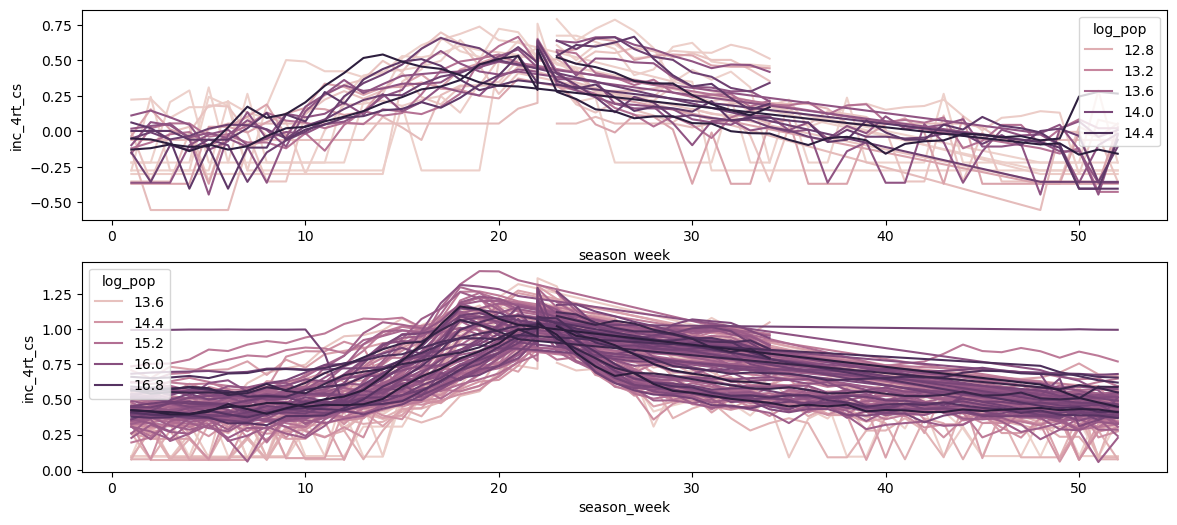

In [43]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(14, 6)
city_to_plot = df.loc[df['agg_level'] == 'city'].assign(season_loc = lambda x: x['season'] + '_' + x['location'])
sns.lineplot(data=city_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax[0])

state_to_plot = df.loc[df['agg_level'] == 'state'].assign(season_loc = lambda x: x['season'] + '_' + x['location'])
sns.lineplot(data=state_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax[1])

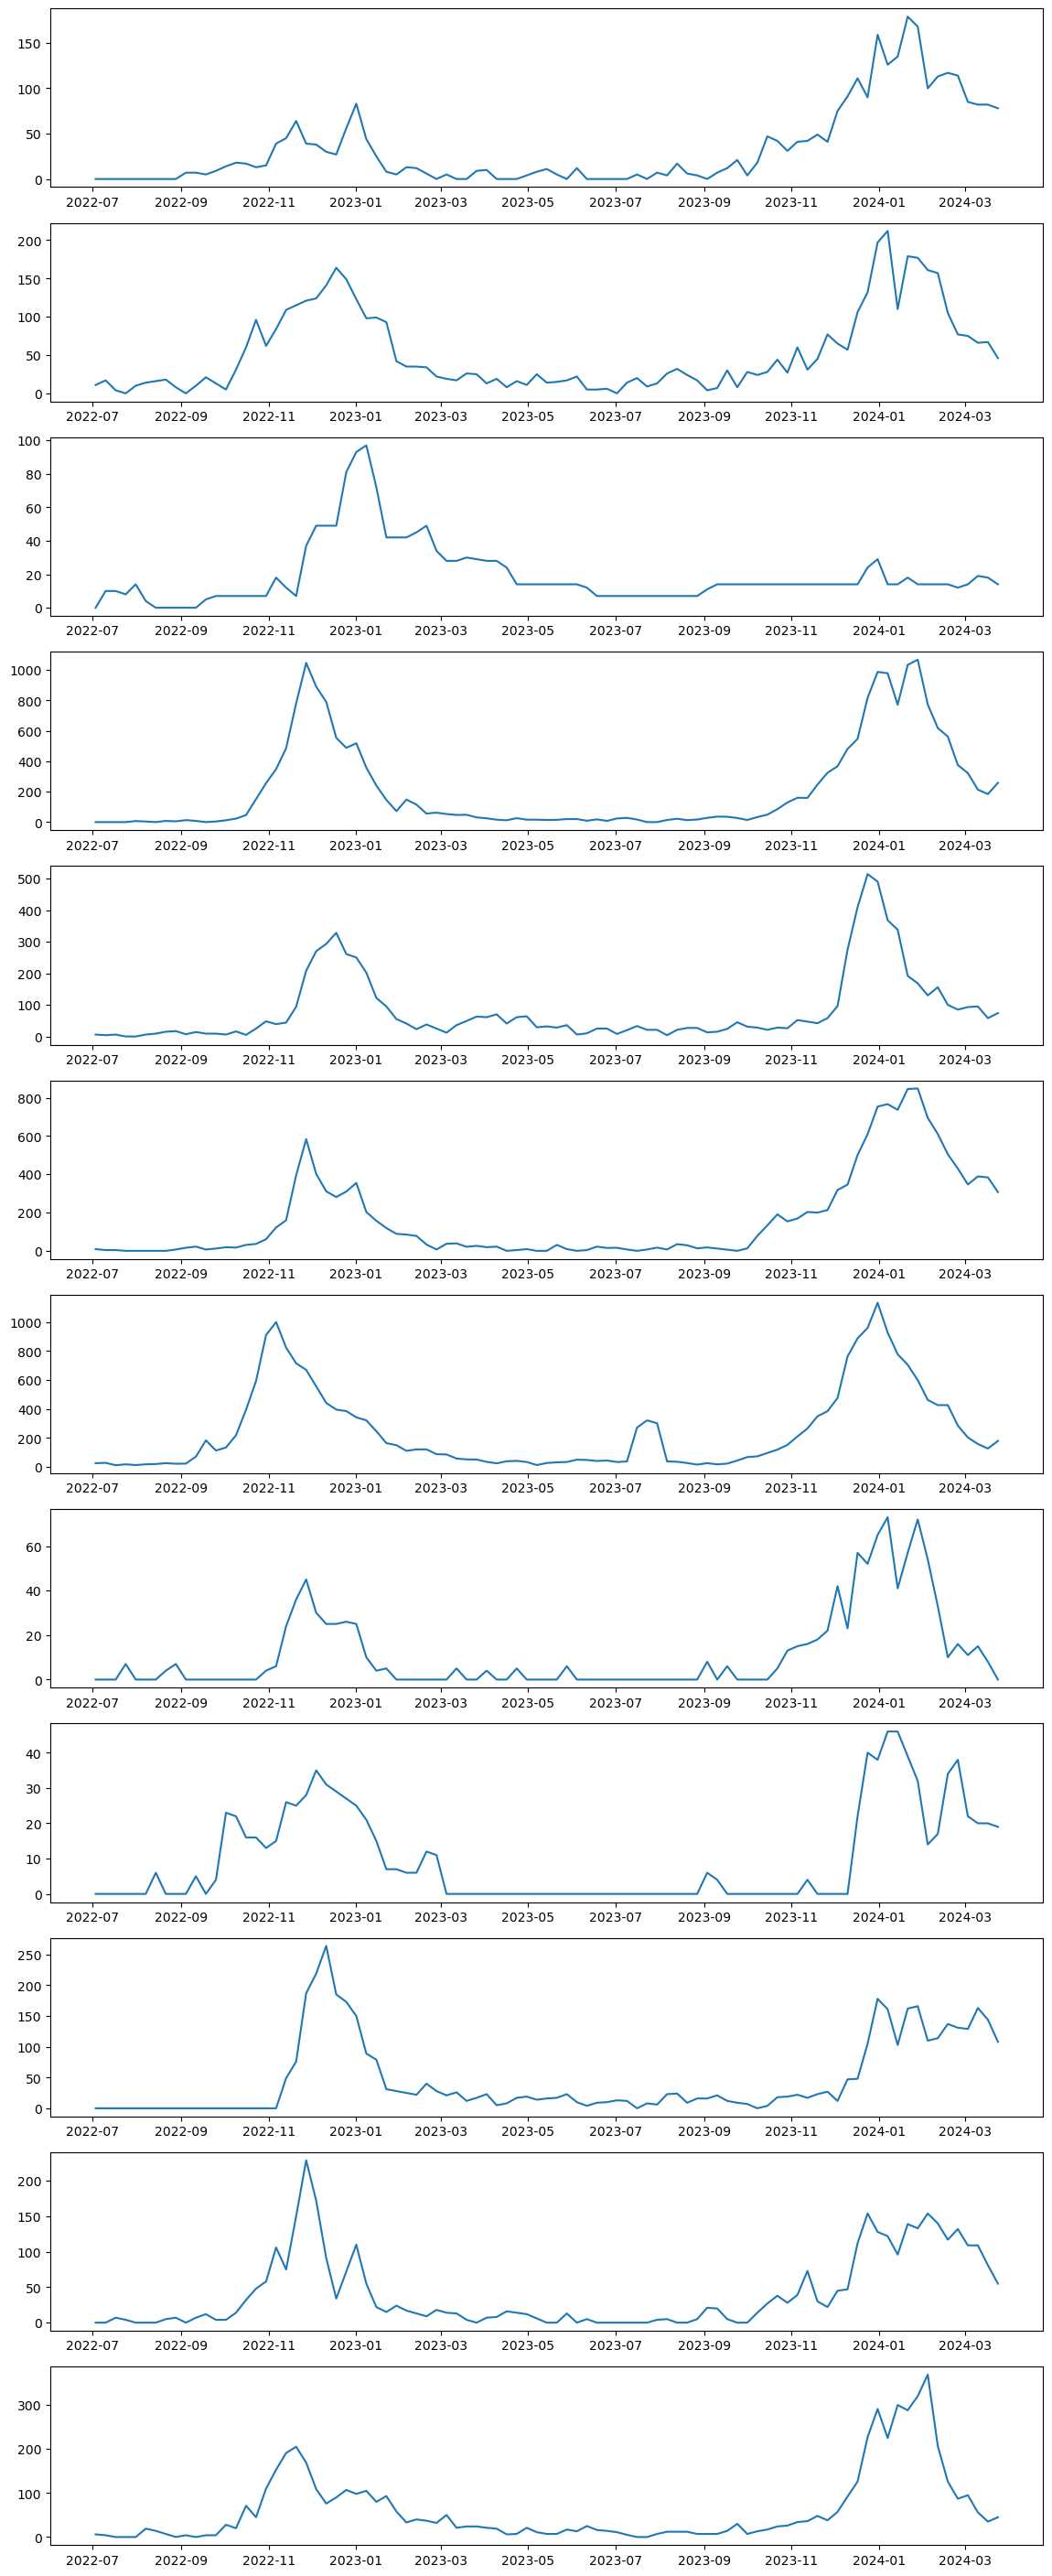

In [44]:
n_loc = len(city_to_plot['location'].unique())

fig, ax = plt.subplots(n_loc, 1)
fig.set_size_inches(14, 3*n_loc)

for i, loc in enumerate(city_to_plot['location'].unique()):
    loc_dat_hhs = city_to_plot.loc[city_to_plot['location'] == loc]
    ax[i].plot(loc_dat_hhs['collection_week'], loc_dat_hhs['influenza_7_day_sum'])


# Calculate features

### Misc. features based on date and location variables

In [14]:
# we already have incidence (transformed scale), season week and log population
feat_names = ['inc_4rt_cs', 'season_week', 'log_pop']

# one-hot encodings of data source, agg_level, and location
for c in ['agg_level' ,'location']:
    ohe = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df, ohe], axis=1)
    feat_names = feat_names + list(ohe.columns)
print(feat_names)
# season week relative to christmas
df = df.merge(
    get_holidays() \
      .query("holiday == 'Christmas Day'") \
      .drop(columns=['holiday', 'date']) \
      .rename(columns={'season_week': 'xmas_week'}),
    how='left',
    on='season') \
  .assign(delta_xmas = lambda x: x['season_week'] - x['xmas_week'])

feat_names = feat_names + ['delta_xmas']


['inc_4rt_cs', 'season_week', 'log_pop', 'agg_level_city', 'agg_level_state', 'location_AK', 'location_AL', 'location_AR', 'location_ARLINGTON', 'location_AUSTIN', 'location_AZ', 'location_CA', 'location_CO', 'location_CORPUS CHRISTI', 'location_CT', 'location_DALLAS', 'location_DC', 'location_DE', 'location_EL PASO', 'location_FL', 'location_FORT WORTH', 'location_GA', 'location_HI', 'location_HOUSTON', 'location_IA', 'location_ID', 'location_IL', 'location_IN', 'location_IRVING', 'location_KS', 'location_KY', 'location_LA', 'location_LAREDO', 'location_LUBBOCK', 'location_MA', 'location_MD', 'location_ME', 'location_MI', 'location_MN', 'location_MO', 'location_MS', 'location_MT', 'location_NC', 'location_ND', 'location_NE', 'location_NH', 'location_NJ', 'location_NM', 'location_NV', 'location_NY', 'location_OH', 'location_OK', 'location_OR', 'location_PA', 'location_PLANO', 'location_PR', 'location_RI', 'location_SAN ANTONIO', 'location_SC', 'location_SD', 'location_TN', 'location_TX

In [15]:
df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': [4, 6],
                'fill_edges': False
            }
        },
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': [3, 5],
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'inc_4rt_cs',
                'group_columns': ['location'],
                'window_size': [2, 4]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'lag',
            'args': {
                'columns': ['inc_4rt_cs'] + new_feat_names,
                'lags': [1, 2]
            }
        }
    ])
feat_names = feat_names + new_feat_names

print(df)
print(feat_names)

     collection_week location  influenza_7_day_sum       pop    log_pop  \
0         2021-07-04       AK                    7  733406.0  13.505455   
1         2021-07-11       AK                    7  733406.0  13.505455   
2         2021-07-18       AK                    7  733406.0  13.505455   
3         2021-07-25       AK                   12  733406.0  13.505455   
4         2021-08-01       AK                    9  733406.0  13.505455   
...              ...      ...                  ...       ...        ...   
9147      2024-02-25       WY                   75  584057.0  13.277754   
9148      2024-03-03       WY                   59  584057.0  13.277754   
9149      2024-03-10       WY                   33  584057.0  13.277754   
9150      2024-03-17       WY                   30  584057.0  13.277754   
9151      2024-03-24       WY                   12  584057.0  13.277754   

      epiweek_week  season_week   season   inc_4rt  inc_4rt_scale_factor  ...  \
0               26

In [16]:
df.keys()

Index(['collection_week', 'location', 'influenza_7_day_sum', 'pop', 'log_pop',
       'epiweek_week', 'season_week', 'season', 'inc_4rt',
       'inc_4rt_scale_factor',
       ...
       'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag1',
       'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag2',
       'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag1',
       'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2',
       'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1',
       'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2', 'inc_4rt_cs_rollmean_w2_lag1',
       'inc_4rt_cs_rollmean_w2_lag2', 'inc_4rt_cs_rollmean_w4_lag1',
       'inc_4rt_cs_rollmean_w4_lag2'],
      dtype='object', length=119)

In [17]:
# import importlib
# featurize = importlib.reload(featurize)

# last date with observed data
# last_obs_date = pd.to_datetime(df.groupby(['location', 'pathogen_covid'])['date'].max().min())
# print(f'last_obs_date: {last_obs_date}')

# how far out to forecast to get to 28 days after due date
# due_date = forecast_date
# extra_horizons_rel_obs = (due_date - last_obs_date.date()).days
# effective_horizon_rel_obs = max_horizon + extra_horizons_rel_obs

# add forecast targets
df_with_pred_targets, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'horizon_targets',
            'args': {
                'columns': 'inc_4rt_cs',
                'horizons': [(i+1) for i in range(max_horizon)]
            }
        }
    ])
feat_names = feat_names + new_feat_names

# we will model the differences between the prediction target and the most
# recent observed value
df_with_pred_targets['delta_target'] = df_with_pred_targets['inc_4rt_cs_target'] - df_with_pred_targets['inc_4rt_cs']

print(new_feat_names)
print(df_with_pred_targets)

['horizon']
     collection_week location  influenza_7_day_sum       pop    log_pop  \
0         2021-07-04       AK                    7  733406.0  13.505455   
1         2021-07-11       AK                    7  733406.0  13.505455   
2         2021-07-18       AK                    7  733406.0  13.505455   
3         2021-07-25       AK                   12  733406.0  13.505455   
4         2021-08-01       AK                    9  733406.0  13.505455   
...              ...      ...                  ...       ...        ...   
9147      2024-02-25       WY                   75  584057.0  13.277754   
9148      2024-03-03       WY                   59  584057.0  13.277754   
9149      2024-03-10       WY                   33  584057.0  13.277754   
9150      2024-03-17       WY                   30  584057.0  13.277754   
9151      2024-03-24       WY                   12  584057.0  13.277754   

      epiweek_week  season_week   season   inc_4rt  inc_4rt_scale_factor  ...  \
0     

In [18]:
df_with_pred_targets['collection_week'].max()

Timestamp('2024-03-24 00:00:00')

In [19]:
df_with_pred_targets['horizon']

0       1
1       1
2       1
3       1
4       1
       ..
9147    4
9148    4
9149    4
9150    4
9151    4
Name: horizon, Length: 36608, dtype: int64

In [20]:
df_with_pred_targets

,collection_week,location,influenza_7_day_sum,pop,log_pop,epiweek_week,season_week,season,inc_4rt,inc_4rt_scale_factor,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
0,2021-07-04,AK,7,733406.0,13.505455,26,48,2021/22,1.627157,3.620570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.448182,1,0.000000
1,2021-07-11,AK,7,733406.0,13.505455,27,49,2021/22,1.627157,3.620570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.448182,1,0.000000
2,2021-07-18,AK,7,733406.0,13.505455,28,50,2021/22,1.627157,3.620570,...,NaN,NaN,NaN,0.448182,NaN,NaN,NaN,0.512756,1,0.064574
3,2021-07-25,AK,12,733406.0,13.505455,29,51,2021/22,1.861597,3.620570,...,NaN,NaN,NaN,0.448182,0.448182,NaN,NaN,0.477207,1,-0.035550
4,2021-08-01,AK,9,733406.0,13.505455,30,52,2021/22,1.732532,3.620570,...,NaN,NaN,NaN,0.480469,0.448182,0.464326,NaN,0.448182,1,-0.029024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9147,2024-02-25,WY,75,584057.0,13.277754,8,30,2024/25,2.942929,3.415294,...,0.900986,-0.006009,-0.031557,0.945468,0.921448,0.932361,0.940420,0.543485,4,-0.315690
9148,2024-03-03,WY,59,584057.0,13.277754,9,31,2024/25,2.771605,3.415294,...,0.930272,-0.010717,-0.006009,0.904470,0.945468,0.912959,0.932361,NaN,4,NaN
9149,2024-03-10,WY,33,584057.0,13.277754,10,32,2024/25,2.396963,3.415294,...,0.896289,-0.026713,-0.010717,0.834167,0.904470,0.889817,0.912959,NaN,4,NaN
9150,2024-03-17,WY,30,584057.0,13.277754,11,33,2024/25,2.340542,3.415294,...,0.838773,-0.062338,-0.026713,0.754471,0.834167,0.829471,0.889817,NaN,4,NaN


In [21]:
df_with_pred_targets['agg_level_city'].isnull().sum()

0

In [22]:
# keep only rows that are in-season
df_with_pred_targets = df_with_pred_targets.query("season_week >= 5 and season_week <= 45")
df_with_pred_targets

,collection_week,location,influenza_7_day_sum,pop,log_pop,epiweek_week,season_week,season,inc_4rt,inc_4rt_scale_factor,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
9,2021-09-05,AK,7,733406.0,13.505455,35,5,2021/22,1.627157,3.620570,...,0.435268,-5.804850e-03,-1.581721e-02,0.448182,0.448182,0.448182,0.455438,0.448182,1,0.000000
10,2021-09-12,AK,7,733406.0,13.505455,36,6,2021/22,1.627157,3.620570,...,0.442377,7.423671e-17,-5.804850e-03,0.448182,0.448182,0.448182,0.448182,0.448182,1,0.000000
11,2021-09-19,AK,7,733406.0,13.505455,37,7,2021/22,1.627157,3.620570,...,0.448182,7.423671e-17,7.423671e-17,0.448182,0.448182,0.448182,0.448182,0.448182,1,0.000000
12,2021-09-26,AK,7,733406.0,13.505455,38,8,2021/22,1.627157,3.620570,...,0.448182,7.423671e-17,7.423671e-17,0.448182,0.448182,0.448182,0.448182,0.389773,1,-0.058410
13,2021-10-03,AK,4,733406.0,13.505455,39,9,2021/22,1.415097,3.620570,...,0.448182,7.423671e-17,7.423671e-17,0.448182,0.448182,0.448182,0.448182,0.087101,1,-0.302671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9147,2024-02-25,WY,75,584057.0,13.277754,8,30,2024/25,2.942929,3.415294,...,0.900986,-6.008912e-03,-3.155671e-02,0.945468,0.921448,0.932361,0.940420,0.543485,4,-0.315690
9148,2024-03-03,WY,59,584057.0,13.277754,9,31,2024/25,2.771605,3.415294,...,0.930272,-1.071744e-02,-6.008912e-03,0.904470,0.945468,0.912959,0.932361,NaN,4,NaN
9149,2024-03-10,WY,33,584057.0,13.277754,10,32,2024/25,2.396963,3.415294,...,0.896289,-2.671290e-02,-1.071744e-02,0.834167,0.904470,0.889817,0.912959,NaN,4,NaN
9150,2024-03-17,WY,30,584057.0,13.277754,11,33,2024/25,2.340542,3.415294,...,0.838773,-6.233808e-02,-2.671290e-02,0.754471,0.834167,0.829471,0.889817,NaN,4,NaN


In [23]:
# "test set" df used to generate look-ahead predictions
df_test = df_with_pred_targets \
    .loc[df_with_pred_targets.collection_week == df_with_pred_targets.collection_week.max()] \
    .copy()
x_test = df_test[feat_names]

# "train set" df for model fitting; target value non-missing
df_train = df_with_pred_targets.loc[~df_with_pred_targets['delta_target'].isna().values]
x_train = df_train[feat_names]
y_train = df_train['delta_target']

In [24]:
# training loop over bags
# for q_level, q_label in zip(q_levels, q_labels):
    # print(q_label)

oob_preds_by_bag = np.empty((x_train.shape[0], num_bags, len(q_levels)))
oob_preds_by_bag[:] = np.nan
test_preds_by_bag = np.empty((x_test.shape[0], num_bags, len(q_levels)))

train_seasons = df_train['season'].unique()

for b in range(num_bags):
    print(f'bag number {b+1}')
    # get indices of observations that are in bag
    bag_seasons = np.random.choice(
        train_seasons,
        size = int(len(train_seasons) * bag_frac_samples),
        replace=False)
    bag_obs_inds = df_train['season'].isin(bag_seasons)
    
    for q_ind, q_level in enumerate(q_levels):
      # fit to bag
      model = lgb.LGBMRegressor(verbosity=-1,
                                  # hist_pool_size=1000,
                                  # objective='mean_absolute_error')
                                objective='quantile',
                                alpha = q_level)
      model.fit(X=x_train.loc[bag_obs_inds, :], y=y_train.loc[bag_obs_inds])
      
      # oob predictions and test set predictions
      oob_preds_by_bag[~bag_obs_inds, b, q_ind] = model.predict(X=x_train.loc[~bag_obs_inds, :])
      test_preds_by_bag[:, b, q_ind] = model.predict(X=x_test)


bag number 1
bag number 2
bag number 3
bag number 4
bag number 5
bag number 6
bag number 7
bag number 8
bag number 9
bag number 10
bag number 11
bag number 12
bag number 13
bag number 14
bag number 15
bag number 16
bag number 17
bag number 18
bag number 19
bag number 20
bag number 21
bag number 22
bag number 23
bag number 24
bag number 25
bag number 26
bag number 27
bag number 28
bag number 29
bag number 30
bag number 31
bag number 32
bag number 33
bag number 34
bag number 35
bag number 36
bag number 37
bag number 38
bag number 39
bag number 40
bag number 41
bag number 42
bag number 43
bag number 44
bag number 45
bag number 46
bag number 47
bag number 48
bag number 49
bag number 50
bag number 51
bag number 52
bag number 53
bag number 54
bag number 55
bag number 56
bag number 57
bag number 58
bag number 59
bag number 60
bag number 61
bag number 62
bag number 63
bag number 64
bag number 65
bag number 66
bag number 67
bag number 68
bag number 69
bag number 70
bag number 71
bag number 72
b

In [25]:
# df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)
# df_test['delta_hat_stage1'] = np.median(test_preds_by_bag, axis=1)

oob_pred_qs = np.nanmedian(oob_preds_by_bag, axis=1)
test_pred_qs = np.median(test_preds_by_bag, axis=1)
test_pred_qs.shape

(256, 23)

In [26]:
test_pred_qs_df = pd.DataFrame(test_pred_qs)
test_pred_qs_df.columns = q_labels
test_pred_qs_df

,0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,...,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99
0,-0.241255,-0.143392,-0.122763,-0.078051,-0.067190,-0.051129,-0.048988,-0.042033,-0.036418,-0.029337,...,-0.007106,-0.003623,0.018875,0.022676,0.037664,0.047120,0.045926,0.062105,0.085110,0.091833
1,-0.130410,-0.079974,-0.068068,-0.056073,-0.055038,-0.046900,-0.046743,-0.042058,-0.030406,-0.034119,...,-0.015316,-0.008009,-0.004861,-0.006042,0.007785,0.009300,0.019887,0.028623,0.041822,0.069744
2,-0.148569,-0.111634,-0.086375,-0.075776,-0.062897,-0.049219,-0.052174,-0.037039,-0.043586,-0.039997,...,-0.014578,-0.008571,-0.000277,0.006913,-0.001297,-0.009194,0.025274,0.033825,0.041999,0.056851
3,-0.311574,-0.218605,-0.169696,-0.119824,-0.155427,-0.091669,-0.067764,-0.066592,-0.055686,-0.050188,...,-0.034417,-0.030795,-0.021284,-0.016542,-0.001255,0.007996,0.037668,0.058222,0.075994,0.105318
4,-0.313233,-0.162071,-0.125973,-0.093019,-0.067426,-0.062566,-0.080121,-0.065868,-0.034985,-0.033989,...,-0.001897,-0.007690,0.009409,0.013495,0.002267,0.026566,0.054188,0.064593,0.109106,0.149613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-0.347975,-0.253905,-0.231058,-0.167724,-0.154772,-0.145525,-0.147081,-0.126575,-0.115937,-0.100420,...,-0.052478,-0.042259,-0.026505,-0.032636,-0.026860,-0.011028,0.023852,0.035008,0.063884,0.096831
252,-0.140471,-0.123648,-0.099212,-0.090080,-0.078043,-0.057130,-0.071476,-0.055856,-0.044152,-0.043471,...,-0.028285,-0.034358,-0.014793,-0.012761,-0.001157,0.005112,0.023411,0.036297,0.055329,0.089792
253,-0.170824,-0.152113,-0.124734,-0.121971,-0.128946,-0.118081,-0.113051,-0.097738,-0.102846,-0.087855,...,-0.033434,-0.045783,-0.032258,-0.025114,0.003850,0.007930,0.027264,0.054936,0.062252,0.074613
254,-0.216759,-0.160469,-0.142483,-0.137473,-0.128259,-0.134077,-0.116966,-0.117837,-0.108095,-0.103596,...,-0.043785,-0.042418,-0.033476,-0.025016,-0.004405,-0.001570,0.031883,0.044170,0.063002,0.071254


In [27]:
df_test.reset_index(drop=True, inplace=True)
df_test

,collection_week,location,influenza_7_day_sum,pop,log_pop,epiweek_week,season_week,season,inc_4rt,inc_4rt_scale_factor,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
0,2024-03-24,AK,64,733406.0,13.505455,12,34,2024/25,2.828538,3.620570,...,0.747973,0.027111,0.007848,0.771717,0.761362,0.755174,0.726967,NaN,1,NaN
1,2024-03-24,AL,488,5108468.0,15.446410,12,34,2024/25,4.700101,6.251617,...,0.799575,-0.027346,-0.024950,0.790890,0.809179,0.814084,0.841242,NaN,1,NaN
2,2024-03-24,AR,465,3067732.0,14.936449,12,34,2024/25,4.643715,5.734062,...,0.991049,-0.017968,-0.002376,0.949751,0.992480,0.974114,0.995075,NaN,1,NaN
3,2024-03-24,ARLINGTON,78,398431.0,12.895290,12,34,2024/25,2.971923,3.253928,...,0.458720,-0.025050,-0.023125,0.454952,0.459112,0.476820,0.498238,NaN,1,NaN
4,2024-03-24,AUSTIN,46,979882.0,13.795187,12,34,2024/25,2.604432,3.474699,...,0.258427,-0.022730,-0.046980,0.282487,0.294227,0.296390,0.320786,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,2024-03-24,VT,82,647464.0,13.380818,12,34,2024/25,3.009308,3.263772,...,1.040539,0.014397,0.024193,0.994608,1.043157,1.014504,0.998698,NaN,4,NaN
252,2024-03-24,WA,476,7812880.0,15.871284,12,34,2024/25,4.670937,5.830047,...,0.815850,-0.005957,-0.004460,0.808286,0.815405,0.820006,0.823372,NaN,4,NaN
253,2024-03-24,WI,666,5910955.0,15.592318,12,34,2024/25,5.080076,5.831908,...,0.919526,-0.002714,0.001164,0.909351,0.918876,0.916061,0.918479,NaN,4,NaN
254,2024-03-24,WV,467,1770071.0,14.386530,12,34,2024/25,4.648700,5.524475,...,1.009668,-0.015837,0.014852,0.952502,0.998038,0.975408,0.995136,NaN,4,NaN


In [28]:
df_test_w_preds = pd.concat([df_test, test_pred_qs_df], axis=1)
print(df_test_w_preds.shape)
df_test_w_preds

(256, 145)


,collection_week,location,influenza_7_day_sum,pop,log_pop,epiweek_week,season_week,season,inc_4rt,inc_4rt_scale_factor,...,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99
0,2024-03-24,AK,64,733406.0,13.505455,12,34,2024/25,2.828538,3.620570,...,-0.007106,-0.003623,0.018875,0.022676,0.037664,0.047120,0.045926,0.062105,0.085110,0.091833
1,2024-03-24,AL,488,5108468.0,15.446410,12,34,2024/25,4.700101,6.251617,...,-0.015316,-0.008009,-0.004861,-0.006042,0.007785,0.009300,0.019887,0.028623,0.041822,0.069744
2,2024-03-24,AR,465,3067732.0,14.936449,12,34,2024/25,4.643715,5.734062,...,-0.014578,-0.008571,-0.000277,0.006913,-0.001297,-0.009194,0.025274,0.033825,0.041999,0.056851
3,2024-03-24,ARLINGTON,78,398431.0,12.895290,12,34,2024/25,2.971923,3.253928,...,-0.034417,-0.030795,-0.021284,-0.016542,-0.001255,0.007996,0.037668,0.058222,0.075994,0.105318
4,2024-03-24,AUSTIN,46,979882.0,13.795187,12,34,2024/25,2.604432,3.474699,...,-0.001897,-0.007690,0.009409,0.013495,0.002267,0.026566,0.054188,0.064593,0.109106,0.149613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,2024-03-24,VT,82,647464.0,13.380818,12,34,2024/25,3.009308,3.263772,...,-0.052478,-0.042259,-0.026505,-0.032636,-0.026860,-0.011028,0.023852,0.035008,0.063884,0.096831
252,2024-03-24,WA,476,7812880.0,15.871284,12,34,2024/25,4.670937,5.830047,...,-0.028285,-0.034358,-0.014793,-0.012761,-0.001157,0.005112,0.023411,0.036297,0.055329,0.089792
253,2024-03-24,WI,666,5910955.0,15.592318,12,34,2024/25,5.080076,5.831908,...,-0.033434,-0.045783,-0.032258,-0.025114,0.003850,0.007930,0.027264,0.054936,0.062252,0.074613
254,2024-03-24,WV,467,1770071.0,14.386530,12,34,2024/25,4.648700,5.524475,...,-0.043785,-0.042418,-0.033476,-0.025016,-0.004405,-0.001570,0.031883,0.044170,0.063002,0.071254


In [30]:
df_test_w_preds.loc[df_test_w_preds['location'] == 'AUSTIN']

,collection_week,location,influenza_7_day_sum,pop,log_pop,epiweek_week,season_week,season,inc_4rt,inc_4rt_scale_factor,...,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99
4,2024-03-24,AUSTIN,46,979882.0,13.795187,12,34,2024/25,2.604432,3.474699,...,-0.001897,-0.007690,0.009409,0.013495,0.002267,0.026566,0.054188,0.064593,0.109106,0.149613
68,2024-03-24,AUSTIN,46,979882.0,13.795187,12,34,2024/25,2.604432,3.474699,...,-0.010395,-0.015223,0.005134,0.003929,-0.002346,0.019942,0.054550,0.077228,0.125036,0.158101
132,2024-03-24,AUSTIN,46,979882.0,13.795187,12,34,2024/25,2.604432,3.474699,...,-0.017714,-0.027787,0.000310,-0.001064,-0.006955,0.013935,0.050875,0.082661,0.129465,0.161893
196,2024-03-24,AUSTIN,46,979882.0,13.795187,12,34,2024/25,2.604432,3.474699,...,-0.021608,-0.026166,-0.000922,-0.004266,-0.008787,0.010446,0.049994,0.081517,0.133569,0.171311


In [32]:
# delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
cols_to_keep = ['location', 'collection_week', 'pop',
                'inc_4rt_cs', 'horizon',
                'inc_4rt_center_factor', 'inc_4rt_scale_factor']
preds_df = df_test_w_preds[cols_to_keep + q_labels]


preds_df = pd.melt(preds_df,
                   id_vars=cols_to_keep,
                   var_name='quantile',
                   value_name = 'delta_hat')

# build data frame with predictions on the original scale
preds_df['inc_4rt_cs_target_hat'] = preds_df['inc_4rt_cs'] + preds_df['delta_hat']
preds_df['inc_4rt_target_hat'] = (preds_df['inc_4rt_cs_target_hat'] + preds_df['inc_4rt_center_factor']) * (preds_df['inc_4rt_scale_factor'] + 0.01)
preds_df['value'] = (np.maximum(preds_df['inc_4rt_target_hat'], 0.0) ** 4 - 0.01 - 0.75**4) * preds_df['pop'] / 100000
preds_df['value'] = np.maximum(preds_df['value'], 0.0)


# keep just required columns and rename to match hub format
preds_df = preds_df[['location', 'collection_week', 'horizon', 'quantile', 'value']] \
    .rename(
        columns={
            'quantile': 'output_type_id'
        })

preds_df['target_end_date'] = preds_df['collection_week'] + pd.to_timedelta(7*preds_df['horizon'], unit='days')
preds_df['output_type'] = 'quantile'
preds_df['target'] = 'wk inc flu hosp'

preds_df


,location,collection_week,horizon,output_type_id,value,target_end_date,output_type,target
0,AK,2024-03-24,1,0.01,1312.289595,2024-03-31,quantile,wk inc flu hosp
1,AL,2024-03-24,1,0.01,150259.137638,2024-03-31,quantile,wk inc flu hosp
2,AR,2024-03-24,1,0.01,72368.195725,2024-03-31,quantile,wk inc flu hosp
3,ARLINGTON,2024-03-24,1,0.01,56.898160,2024-03-31,quantile,wk inc flu hosp
4,AUSTIN,2024-03-24,1,0.01,48.138181,2024-03-31,quantile,wk inc flu hosp
...,...,...,...,...,...,...,...,...
5883,VT,2024-03-24,4,0.99,3105.585298,2024-04-21,quantile,wk inc flu hosp
5884,WA,2024-03-24,4,0.99,336266.619671,2024-04-21,quantile,wk inc flu hosp
5885,WI,2024-03-24,4,0.99,278421.204331,2024-04-21,quantile,wk inc flu hosp
5886,WV,2024-03-24,4,0.99,71429.977265,2024-04-21,quantile,wk inc flu hosp


In [33]:
# sort quantiles to avoid quantile crossing
gcols = ['location', 'collection_week', 'horizon', 'target_end_date', 'target', 'output_type']
g = preds_df.set_index(gcols).groupby(gcols)
preds_df = g[['output_type_id', 'value']] \
  .transform(lambda x: x.sort_values()) \
  .reset_index()
preds_df

,location,collection_week,horizon,target_end_date,target,output_type,output_type_id,value
0,AK,2024-03-24,1,2024-03-31,wk inc flu hosp,quantile,0.01,1312.289595
1,AL,2024-03-24,1,2024-03-31,wk inc flu hosp,quantile,0.01,150259.137638
2,AR,2024-03-24,1,2024-03-31,wk inc flu hosp,quantile,0.01,72368.195725
3,ARLINGTON,2024-03-24,1,2024-03-31,wk inc flu hosp,quantile,0.01,56.898160
4,AUSTIN,2024-03-24,1,2024-03-31,wk inc flu hosp,quantile,0.01,48.138181
...,...,...,...,...,...,...,...,...
5883,VT,2024-03-24,4,2024-04-21,wk inc flu hosp,quantile,0.99,3105.585298
5884,WA,2024-03-24,4,2024-04-21,wk inc flu hosp,quantile,0.99,336266.619671
5885,WI,2024-03-24,4,2024-04-21,wk inc flu hosp,quantile,0.99,278421.204331
5886,WV,2024-03-24,4,2024-04-21,wk inc flu hosp,quantile,0.99,71429.977265


In [34]:
if not Path('/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/Dongah/output').exists():
    Path('/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/Dongah/output').mkdir(parents=True)

preds_df.to_csv(f'/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/Dongah/output/{str(forecast_date)}-UMass-gbq_qr.csv', index=False)

In [35]:
str(forecast_date)

'2024-03-24'

In [ ]:
os.getcwd()

'/Users/dk29776/Dropbox/UTAustin/Forecasting'

In [ ]:
preds_df[(preds_df['city'] == 'AUSTIN') & (preds_df['collection_week'] >= '2024-01-01')]

,city,collection_week,horizon,target_end_date,target,output_type,output_type_id,value
1,AUSTIN,2024-03-24,1,2024-03-31,wk inc flu hosp,quantile,0.01,47.077621
13,AUSTIN,2024-03-24,2,2024-04-07,wk inc flu hosp,quantile,0.01,47.077621
25,AUSTIN,2024-03-24,3,2024-04-14,wk inc flu hosp,quantile,0.01,47.077621
37,AUSTIN,2024-03-24,4,2024-04-21,wk inc flu hosp,quantile,0.01,47.467532
49,AUSTIN,2024-03-24,1,2024-03-31,wk inc flu hosp,quantile,0.025,174.466947
...,...,...,...,...,...,...,...,...
1045,AUSTIN,2024-03-24,4,2024-04-21,wk inc flu hosp,quantile,0.975,578.877878
1057,AUSTIN,2024-03-24,1,2024-03-31,wk inc flu hosp,quantile,0.99,766.362180
1069,AUSTIN,2024-03-24,2,2024-04-07,wk inc flu hosp,quantile,0.99,766.362180
1081,AUSTIN,2024-03-24,3,2024-04-14,wk inc flu hosp,quantile,0.99,784.136141


In [ ]:
d2[(d2['city'] == 'AUSTIN') & (d2['collection_week'] >= '2024-01-01')]

,collection_week,state,city,influenza_7_day_sum,city_2023,state_2023,log_citypop,epiweek_week,season_week,next_year,season,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
718883,2024-01-07,TX,AUSTIN,212,979882.0,30503301.0,13.795187,1,23,2025,2024/25,3.815831,3.474699,0.558002,0.537023
722492,2024-01-14,TX,AUSTIN,110,979882.0,30503301.0,13.795187,2,24,2025,2024/25,3.238605,3.474699,0.392356,0.537023
726103,2024-01-21,TX,AUSTIN,179,979882.0,30503301.0,13.795187,3,25,2025,2024/25,3.657795,3.474699,0.512650,0.537023
729714,2024-01-28,TX,AUSTIN,177,979882.0,30503301.0,13.795187,4,26,2025,2024/25,3.647535,3.474699,0.509706,0.537023
733321,2024-02-04,TX,AUSTIN,161,979882.0,30503301.0,13.795187,5,27,2025,2024/25,3.562158,3.474699,0.485206,0.537023
736927,2024-02-11,TX,AUSTIN,157,979882.0,30503301.0,13.795187,6,28,2025,2024/25,3.539825,3.474699,0.478797,0.537023
740534,2024-02-18,TX,AUSTIN,105,979882.0,30503301.0,13.795187,7,29,2025,2024/25,3.201162,3.474699,0.381611,0.537023
744142,2024-02-25,TX,AUSTIN,77,979882.0,30503301.0,13.795187,8,30,2025,2024/25,2.962353,3.474699,0.313080,0.537023
747749,2024-03-03,TX,AUSTIN,75,979882.0,30503301.0,13.795187,9,31,2025,2024/25,2.942929,3.474699,0.307506,0.537023
751353,2024-03-10,TX,AUSTIN,66,979882.0,30503301.0,13.795187,10,32,2025,2024/25,2.850378,3.474699,0.280947,0.537023
